<a href="https://colab.research.google.com/github/Sim589/Labyrinths/blob/main/TFL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# London Labyrinth CNN Classifyer

 Importing necessary modules

In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from google.colab import drive
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Import the Original Dataset

The images are stored in the Git `Original Images` folder with the following structure:

 `Original Images`/
  - 1 - `Chesham`/
    - CheshamCloseup.jpg
    - CheshamSurrounding.jpg
  - 2 - `Chalford & Latimer`/
    - ChalfordCloseup.jpg
    - ChalfordSurrounding.jpg \

 etc.


In [15]:
!git clone https://github.com/Sim589/Labyrinths
data_dir = '/content/Labyrinths/Original Images'
original_dataset = datasets.ImageFolder(root=data_dir, transform=None)

Cloning into 'Labyrinths'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 54 (delta 0), reused 48 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (54/54), 2.32 MiB | 30.79 MiB/s, done.


In [20]:
class AugmentDataset(Dataset):
    def __init__(self, original_dataset, n_augmentations=1):
        self.original_dataset = original_dataset
        self.n_augmentations = n_augmentations
        self.augmentation_transforms = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((200, 200)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(30),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.GaussianBlur(kernel_size=3),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    def __len__(self):
        return len(self.original_dataset) * self.n_augmentations

    def __getitem__(self, idx):
        original_idx = idx // self.n_augmentations
        image, label = self.original_dataset[original_idx]
        augmented_image = self.augmentation_transforms(image)
        return augmented_image, label

def plot_dataset(data_loader, class_names):
    def imshow(img, ax):
        img = img * 0.5 + 0.5  # Undo normalization
        np_img = img.numpy()
        np_img = np.transpose(np_img, (1, 2, 0))
        ax.imshow(np_img.squeeze(), cmap="gray")
        ax.axis('off')

    # Extract images and labels from the data loader
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    # Calculate the number of rows and columns for subplots
    num_classes = len(class_names)
    num_cols = min(num_classes, 5)  # Limit columns to 5 to avoid the error
    num_rows = (num_classes + num_cols - 1) // num_cols

    # Visualize sample images for each station class
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 9))  # Adjusted subplots
    fig.suptitle("Sample Augmented Images for Each Station", fontsize=16)

    for i, (station, ax) in enumerate(zip(class_names, axes.flat)):
        station_images = images[labels == i][:2]
        ax.set_title(station, fontsize=12)

        for row in range(len(station_images)):
            imshow(station_images[row], ax) # Plot on the current subplot

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# Create augmented datasets for training and testing
# n_augmentations is the number of images that will be generated from any 1 original photo
n_augmentations = 15
augmented_training_dataset = AugmentDataset(original_dataset, n_augmentations)
augmented_test_dataset = AugmentDataset(original_dataset, n_augmentations)

# Create DataLoaders for both training and testing datasets
train_loader = DataLoader(augmented_training_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(augmented_test_dataset, batch_size=32, shuffle=False)
class_names = original_dataset.classes

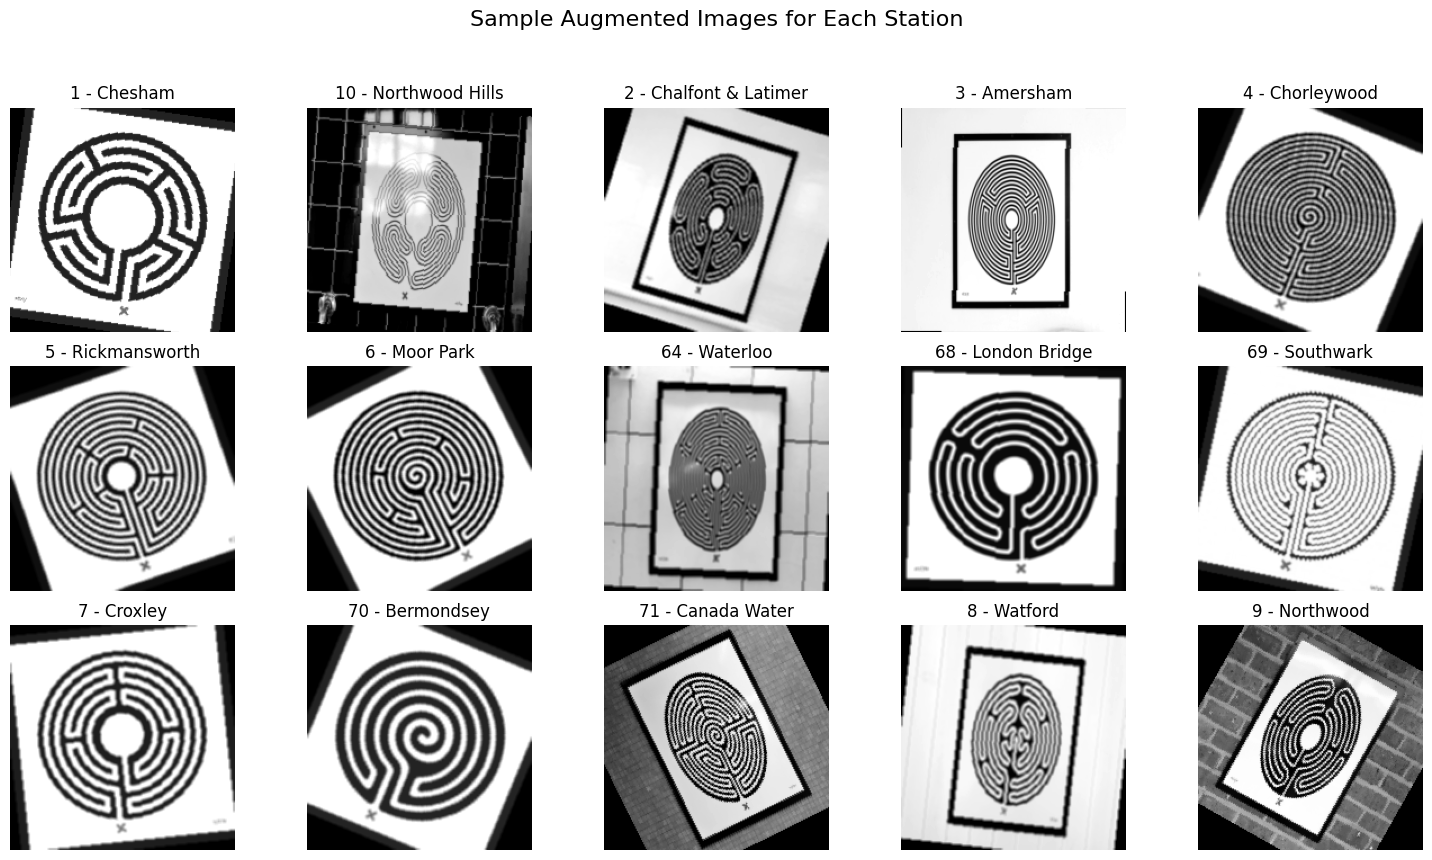

In [19]:
plot_dataset(train_loader, class_names)

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes, input_size=200, device='cpu'):
        #We love stealing from the inbuilt pytorch nn.Module
        super(CNN, self).__init__()
        self.device = device

        # Define convolutional and pooling layers
        # This is probably overkill size, and I will cut this down gradually
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Move layers to the specified device (probably GPU)
        self.conv1.to(device)
        self.conv2.to(device)
        self.conv3.to(device)
        self.pool.to(device)

        # Calculate flattened size after convolution and pooling layers
        example_input = torch.randn(1, 1, input_size, input_size, device=self.device)
        example_output = self.pool(self.conv3(self.pool(self.conv2(self.pool(self.conv1(example_input))))))
        self.flattened_size = example_output.numel()

        # Define fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 256).to(device)
        self.fc2 = nn.Linear(256, num_classes).to(device)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)              #Flatten the photo like a pancake
        x = F.relu(self.fc1(x))                #All my homies love relu
        x = self.fc2(x)
        return x

    def train_model(self, train_loader, criterion, optimizer, num_epochs=10):
        self.train()
        for epoch in range(num_epochs):
            running_loss = 0.0
            for images, labels in train_loader:
                images, labels = images.to(self.device), labels.to(self.device)

                optimizer.zero_grad()             # Zero the gradients
                outputs = self(images)            # Forward pass
                loss = criterion(outputs, labels) # Calculate loss
                loss.backward()                   # Backward pass
                optimizer.step()                  # Update weights

                running_loss += loss.item()

            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

    def evaluate_model(self, test_loader):
        self.eval()  # Set the model to evaluation mode to not mess with gradients
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(self.device)
                outputs = self(images)
                _, predicted = torch.max(outputs.data, 1)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        return np.array(all_labels), np.array(all_preds)

    def plot_confusion_matrix(self, true_labels, predicted_labels, class_names):
        cm = confusion_matrix(true_labels, predicted_labels)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.xticks(rotation=90)
        plt.show()


Epoch 1/15, Loss: 2.9061
Epoch 2/15, Loss: 2.4422
Epoch 3/15, Loss: 1.8566
Epoch 4/15, Loss: 1.1280
Epoch 5/15, Loss: 1.0212
Epoch 6/15, Loss: 0.5854
Epoch 7/15, Loss: 0.3867
Epoch 8/15, Loss: 0.3918
Epoch 9/15, Loss: 0.3918
Epoch 10/15, Loss: 0.1683
Epoch 11/15, Loss: 0.1861
Epoch 12/15, Loss: 0.0851
Epoch 13/15, Loss: 0.0746
Epoch 14/15, Loss: 0.0384
Epoch 15/15, Loss: 0.0202


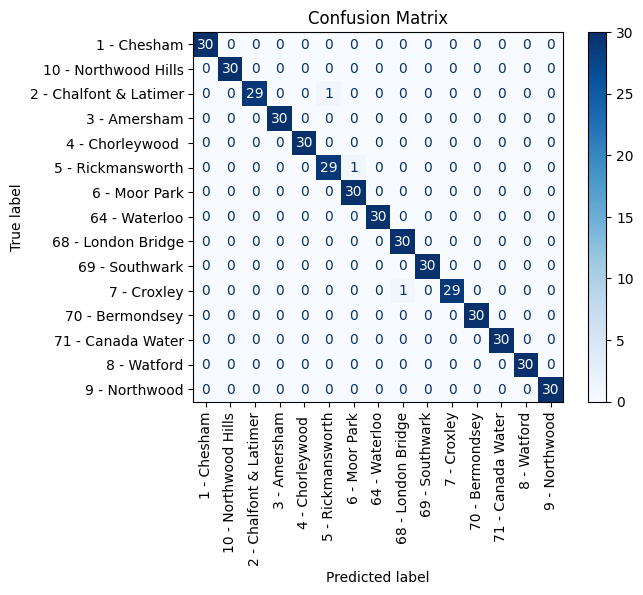

In [ ]:
num_classes = len(class_names)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  #Would recommend switching runtime on google colab to GPU
model = CNN(num_classes, device=device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.train_model(train_loader, criterion, optimizer, num_epochs=15)
true_labels, predicted_labels = model.evaluate_model(test_loader)
model.plot_confusion_matrix(true_labels, predicted_labels, class_names)